**About the data:** In accordance with section 22D of the Public Sector Management Act 1994, the Public Sector Commissioner reports annually to Parliament on the state of public sector administration and management, and on the extent of compliance with public sector standards and ethical codes. One of the primary information sources used for the State of the WA public sector report 2015 - Creating opportunities is the employee perception survey (EPS). <br> 
The EPS captures employee views about factors affecting their workplace, such as leadership, communication, work/life balance and performance development. This information helps to understand organisational culture across the public sector and is essential in identifying areas for further consideration and acknowledging good practice. <br>
The EPS is typically conducted in each public sector body with more than 20 employees once every five years. Different regional offices for the largest agencies, Department of Health and Department of Education, are surveyed every year.

For more information on the data set, please refer to https://data.gov.au/dataset/public-sector-commission-wa-employee-perception-survey-2015. <br>

The PDF version of the actual survey form can be found at https://data.gov.au/dataset/public-sector-commission-wa-employee-perception-survey-2015/resource/f6b6fb5f-0370-4524-a159-9a31840e1e5a/proxy

References: <br>
- https://www.dataquest.io/blog/machine-learning-preparing-data/
- Plotly code was resued from https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial
- Graphviz visualisation code was resued from `decision_trees` notebook `General Assembly, Sydney` taught by Dima Galat. (https://www.linkedin.com/in/dimagalat/)

In [1]:
#libraries
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np

#config
pd.set_option('display.max_colwidth', 5000)

# pd.set_option("display.max_rows",120)
pd.set_option("display.max_columns",120)

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
import graphviz 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, \
                             AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz 
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score,f1_score,cohen_kappa_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
import mglearn
import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

In [2]:
#import data
data_path = '/Users/user/Desktop/Folders/Data_Scientist/data/public-sector-commission-eps-2015-data.xlsx'

#read files
survey = pd.read_excel(data_path, na_values = 8,sheet_name = 'Data')

survey_question = pd.read_excel(data_path, na_values = 8, 
                                sheet_name = 'Question key')

survey_answer_values = pd.read_excel(data_path, sheet_name = 'Response key')

#create dictionary
survey_dict = dict(zip(survey_question['Question ID'], survey_question['Question ']))

In [3]:
#drop columns with >50% null values
print("Number of columns in our dataframe: {:d}".format(survey.shape[1]))
half_count = len(survey) / 2
survey = survey.dropna(thresh=half_count,axis=1)
print("Number of columns left in our dataframe after drop: {:d}". \
      format(survey.shape[1]))

Number of columns in our dataframe: 110
Number of columns left in our dataframe after drop: 80


**Exploratory Data Analysis**

In [4]:
#survey questions description
survey_question.rename(columns = {'Question ID' : 'question_id',
                                  'Question ': 'description'}, inplace = True)

#new dataframe for eda
survey_dtypes = pd.DataFrame(survey.dtypes,columns=['dtypes'])
survey_dtypes.reset_index(inplace = True)
survey_dtypes.rename(columns = {'index' : 'question_id'},inplace = True)
survey_dtypes['unique_values'] = list(survey.nunique())

#get first row values from main df
survey_dtypes['first_row_value'] = survey.loc[0].values

#new col - 'category' based on employee survey form 
survey_dtypes['question_category'] = 'null'
survey_dtypes.loc[0:2,'question_category']   = 'overall_job_satisfaction'
survey_dtypes.loc[2:9,'question_category']   = 'current_job_related'
survey_dtypes.loc[10:23,'question_category'] = 'agency_related'
survey_dtypes.loc[24:25,'question_category'] = 'workplace_communication'
survey_dtypes.loc[26:29,'question_category'] = 'immediate_supervisor'
survey_dtypes.loc[30:33,'question_category'] = 'immediate_work_group'
survey_dtypes.loc[34:37,'question_category'] = 'performance_development'
survey_dtypes.loc[38:41,'question_category'] = 'equity_and_diversity'
survey_dtypes.loc[42:45,'question_category'] = 'misc'
survey_dtypes.loc[46:52,'question_category'] = 'ethical_behaviour'
survey_dtypes.loc[53:54,'question_category'] = 'misc'
survey_dtypes.loc[55:69,'question_category'] = 'ethical_behaviour_at_workplace'
survey_dtypes.loc[70:74,'question_category'] = 'misc'
survey_dtypes.loc[75:78,'question_category'] = 'further_information'
survey_dtypes.loc[79:,'question_category'] = 'agency_size'

In [5]:
#create copy called 'preview' for eda
preview = survey_dtypes.merge(survey_question, on = 'question_id', how = 'left')

As we saw in our `survey` shape, it had 80 columns, therefore, preview will have 80 rows. So, we will break it down to 4 parts of 20 rows each. 

As you explore the features to better understand each of them, you'll want to pay attention to any column that: 

- leaks information from the future
- is formatted poorly,<br>
- requires more data or a lot of preprocessing to turn into useful a feature, or
- contains redundant information.

**First group of columns:**

In [6]:
#Preview first 20 rows
preview[:21]

,question_id,dtypes,unique_values,first_row_value,question_category,description
0,overall_job_satisfaction,float64,7,1.0,overall_job_satisfaction,Please indicate your level of satisfaction with: My job overall
1,overall_agency_satisfaction,float64,7,2.0,overall_job_satisfaction,Please indicate your level of satisfaction with: My agency as an employer
2,job_allows_to_utilise_skills,float64,7,1.0,current_job_related,"My job allows me to utilise my skills, knowledge and abilities"
3,clarity_about_responsibilities,float64,7,2.0,current_job_related,I am clear what my duties and responsibilities are
4,understand_works_contribution,float64,7,1.0,current_job_related,I understand how my work contributes to my agency’s objectives
5,authority_to_do_job,float64,7,2.0,current_job_related,"I have the authority (e.g. the necessary delegations, autonomy, level of responsibility) to do my job effectively"
6,sufficiently_challenged_by_work,float64,7,2.0,current_job_related,I am sufficiently challenged by my work
7,recognition,float64,7,2.0,current_job_related,I am recognised for the contribution I make
8,career_progression_opportunities,float64,7,2.0,current_job_related,I am satisfied with the opportunities available to me for career progression in my current agency
9,proud_to_work_in_WPS,float64,7,1.0,current_job_related,I am proud to work in the Western Australian public sector


Our **target** variable is **overall_job_satisfaction**. As part of this project, **we will NOT be predicting** overall satisfaction with the agency - 'overall_agency_satisfaction'.

Questions from `10` to `16` are related to the overall satisfaction with the Agency and not Job Satisfaction in itself, therefore, we will be dropping these columns as they are unrelated to what we want to predict. We will be dropping these columns as a whole OR we could feature engineer to keep the 'median'. 

In [7]:
#rename target
survey.rename({'overall_job_satisfaction':'target'},inplace = True, axis = 1)

#drop columns
drop_list = np.array(survey_dtypes.loc[11:20,'question_id'])
survey.drop(drop_list,axis=1,inplace = True)
survey.drop('overall_agency_satisfaction',axis=1, inplace = True)

**Second group of columns:**

In [8]:
#preview next 20 rows
preview[21:41]

,question_id,dtypes,unique_values,first_row_value,question_category,description
21,proud_to_work_here,float64,7,1.0,agency_related,I am proud to tell others I work for my agency
22,recommend_others_to_work_here,float64,7,1.0,agency_related,I would recommend my agency as a great place to work
23,likely_to_leave,float64,3,3.0,agency_related,It is likely that you will leave your agency within:
24,effective_communication,float64,7,2.0,workplace_communication,"In my work area, communication between senior managers and other employees is effective"
25,input_is_heard,float64,7,2.0,workplace_communication,My input is adequately sought and considered about decisions that directly affect me
26,manager_has_good_interpersonal_skills,float64,7,2.0,immediate_supervisor,My immediate supervisor makes use of appropriate communication and interpersonal skills when dealing with me
27,business_risk_communication,float64,7,2.0,immediate_supervisor,My immediate supervisor effectively communicates with me about business risks impacting my work group
28,supervisor_manages_well,float64,7,2.0,immediate_supervisor,My immediate supervisor is effective in managing people
29,poor_employee_performance_dealt_with,float64,7,2.0,immediate_supervisor,My immediate supervisor appropriately deals with employees who perform poorly
30,effective_utilisation_of_time_and_resources,float64,7,1.0,immediate_work_group,The people in my work group use their time and resources efficiently


We will be dropping `agency_related` columns `21-23`. <br>
We will be keeping all the other columns. 

In [9]:
#drop columns
drop_list = np.array(survey_dtypes.loc[21:23,'question_id'])
survey.drop(drop_list, axis=1, inplace = True)

**Third group of columns:**

In [10]:
#preview next 20 rows
preview[41:61]

,question_id,dtypes,unique_values,first_row_value,question_category,description
41,different_diversity_treated_well,float64,7,1.0,equity_and_diversity,Your co-workers treat employees from all diversity groups with equal respect
42,B6,float64,3,2.0,misc,Are you aware of the Public Sector Standards in Human Resource Management?
43,B8,float64,3,1.0,misc,"If you have been employed in your agency for more than 12 months, have you participated in one or more formal, documented performance management meetings with your immediate supervisor in the past 12 months?"
44,B8ai,float64,1,1.0,misc,"If yes, which of the following topics were discussed within these formal, documented, meetings?: My work performance over the last year"
45,performance_and_development,float64,6,1.0,misc,How often do you meet with your immediate supervisor informally in a setting that allows for discussion about performance and development matters?
46,encourages_ethical_behaviour,float64,7,1.0,ethical_behaviour,My agency actively encourages ethical behaviour by all of its employees
47,senior_manager_ethics_are_strong,float64,7,1.0,ethical_behaviour,Senior managers in my agency lead by example in ethical behaviour
48,conflicts_managed_well,float64,7,2.0,ethical_behaviour,Conflicts of interest are identified and managed effectively in my workplace
49,supervisor_honesty_and_integrity,float64,7,1.0,ethical_behaviour,My immediate supervisor demonstrates honesty and integrity in the workplace
50,coworkers_honesty_and_integrity,float64,7,1.0,ethical_behaviour,My co-workers demonstrate honesty and integrity in the workplace


We will be dropping the `misc` category questions and will be keeping questions related to `ethical_behaviour`. <br>
Questions related to `ethical_behaviour_at_workplace` are dummy variables. We shall be keeping the round median() value to not lose a lot of information and yet, significiantly reduce the number of columns. 

In [11]:
#drop columns
drop_list = np.array(survey_dtypes.loc[42:45,'question_id'])
drop_list = np.append(drop_list, np.array(survey_dtypes.loc[53:54,'question_id']))
survey.drop(drop_list, axis=1, inplace = True)

In [12]:
#capture aggregate information
survey['ethical_behaviour_med'] = survey.iloc[:,55:60].median(axis = 1)

#drop individual cols
drop_list = np.array(survey_dtypes.loc[55:60,'question_id'])
survey.drop(drop_list, axis=1, inplace = True)

**Fourth group of columns:**

In [13]:
#preview last 20 rows
preview[61:]

,question_id,dtypes,unique_values,first_row_value,question_category,description
61,drug_use,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Illicit drug use and/or alcohol intoxication"
62,assault,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Inappropriate physical behaviour (e.g. assault, indecent behaviour)"
63,confidential_information_leakage,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Inappropriate access to or use of confidential information or unauthorised disclosure of information"
64,bribes_or_theft,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Workplace bribes or theft (e.g. computers, cash or workplace equipment)"
65,misuse_of_public_resources,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Misuse of public resources (e.g. unauthorised use of vehicles, misuse of corporate credit card)"
66,fradulent_behaviour,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Fraudulent behaviour or falsification of information or records"
67,neglect_of_duty,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Neglect of duty (e.g. intentionally failing to perform work duties)"
68,criminal_behaviour,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Engaging in criminal behaviour outside work"
69,having_two_jobs,float64,5,1.0,ethical_behaviour_at_workplace,"Have you witnessed any of the following types of unethical behaviour in your workplace in the last 12 months, and if so how often?: Secretly holding another job outside government without agency permission"
70,C4ii,float64,4,NaN,misc,"If you have witnessed unethical behaviour in your workplace, did you report it?"


We will be keeping the `further_information` category and dropping the `misc` and `agency_size` columns. 

In [14]:
#drop columns 
drop_list = drop_list = np.array(survey_dtypes.loc[61:74,'question_id'])
survey.drop(drop_list, axis=1, inplace = True)
survey.drop('agency_size', axis=1, inplace = True)

In [15]:
survey.shape

(11405, 40)

We have significiantly reduced our number of columns from 110 to 40. 

In [16]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
    
#Function call 
missing_values_table(survey).head()

Your selected dataframe has 40 columns.
There are 39 columns that have missing values.


,Missing Values,% of Total Values
purchasing_decisions_not_influenced_by_incentive,1354,11.9
poor_employee_performance_dealt_with,1132,9.9
conflicts_managed_well,907,8.0
innovative_approach,789,6.9
adequate_opportunity_to_be_a_leader,525,4.6


In [17]:
#fillna with mode
survey = survey.apply(lambda x:x.fillna(x.value_counts().index[0]))

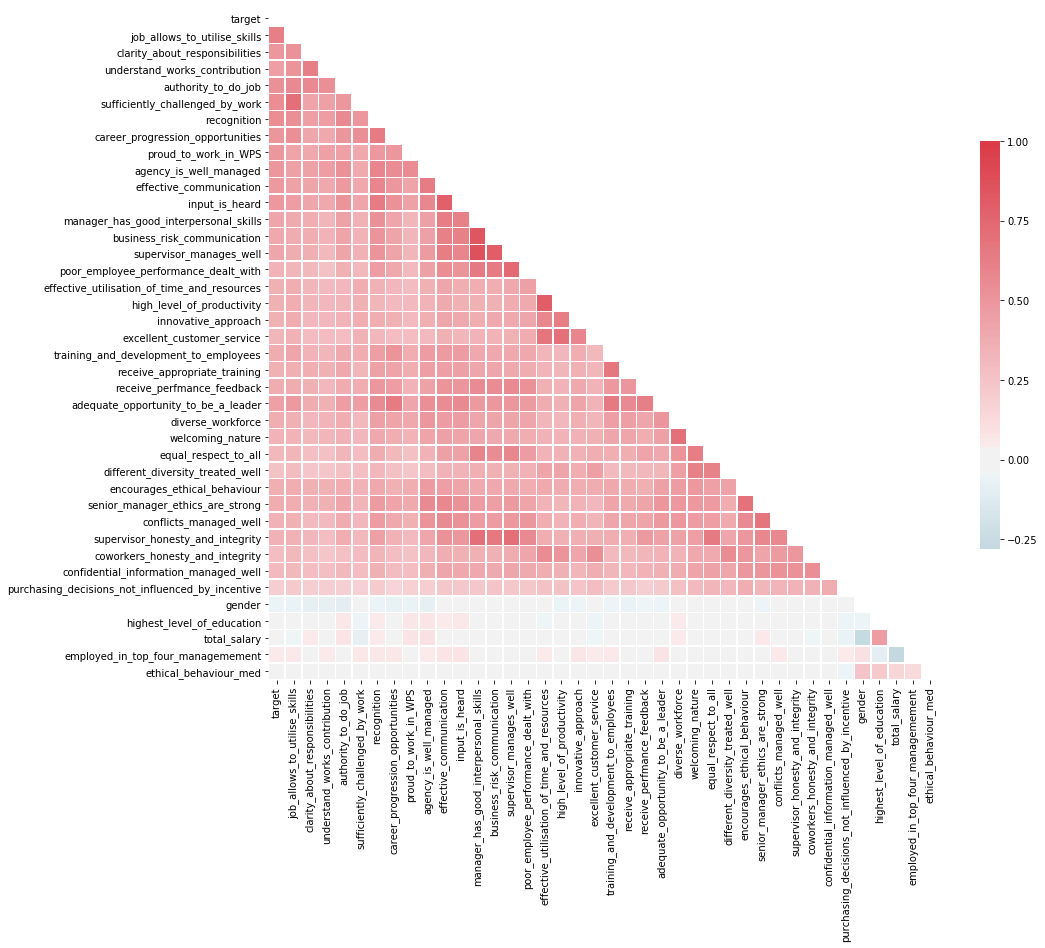

In [31]:
corr = survey.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
a = sns.heatmap(corr, mask=mask, cmap=cmap, center = 0, 
            vmax=1, ax = ax, square = True,
            linewidths=.5, cbar_kws={"shrink":0.5} );

Most features are correlated to each other. Let's find out which are the features that are the most correlated to our target variable.

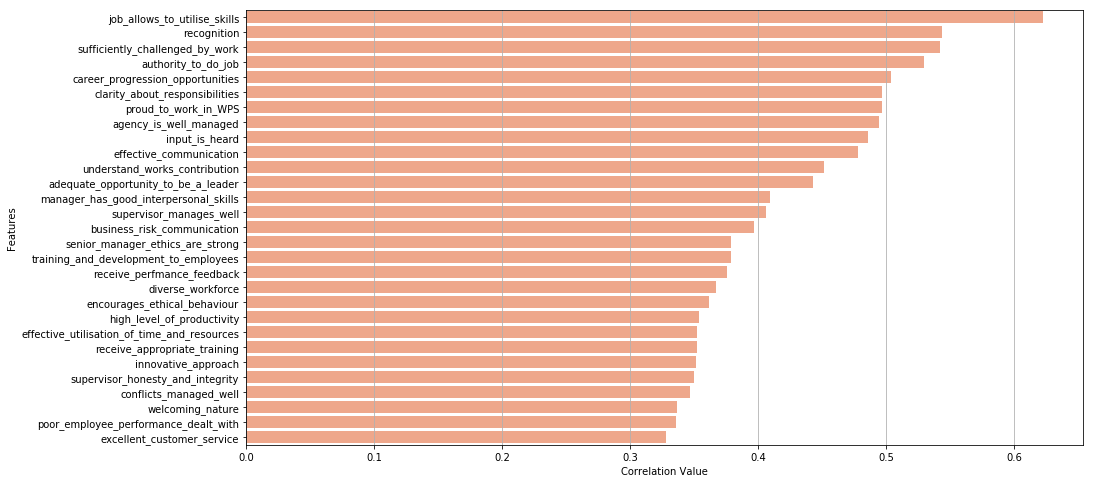

In [19]:
correlations_neg =  survey.corr()['target'].sort_values()
correlations_pos = survey.corr()['target'].sort_values(ascending = False)

#positive correlation
fig,ax = plt.subplots(figsize = (15,8))
df = pd.DataFrame(correlations_pos.head(30))[1:]
# df.plot(kind = 'barh', ax = ax, color = 'lightsalmon');
# plt.title('Factors that have high correlation with Job Satisfaction');
# ax.grid()
a = sns.barplot(x='target',y='index', data = df.reset_index(), color = 'lightsalmon', orient = 'h');
ax.set_xlabel('Correlation Value');
ax.set_ylabel('Features');
ax.grid(axis = 'x')

It seems like 'My job allows me to utilise my skills, knowledge and abilitie' plays the most important role in Job Satisfaction. 

In [20]:
#for meaningful plots
response_key = {
    1:'Very satisfied',
    2: 'Moderately satisfied',
    3: 'Mildly satisfied',
    4: 'Neither satisfied nor dissatisfied',
    5:'Mildly dissatisfied',
    6:'Moderately dissatisfied',
    7:'Very dissatisfied'
                }

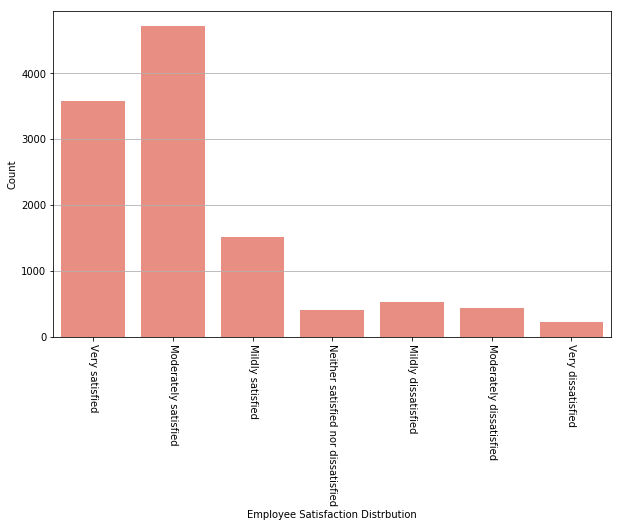

In [21]:
#plot target variable
survey['target_plot'] = survey['target'].map(response_key)

fig,ax = plt.subplots(figsize = (10,6))

a = sns.countplot(x = 'target_plot', data = survey, 
                  color = 'salmon', 
                  order = ['Very satisfied','Moderately satisfied','Mildly satisfied',
                           'Neither satisfied nor dissatisfied','Mildly dissatisfied',
                           'Moderately dissatisfied','Very dissatisfied']);

ax.set(xlabel = 'Employee Satisfaction Distrbution');
ax.set(ylabel = 'Count');
ax.grid(which = 'major', axis = 'y')

#change xtick rotation
for item in a.get_xticklabels():
    item.set_rotation(-90)

In [22]:
#define feature_cols,X,y
feature_cols = survey.drop(['target','target_plot'],axis=1).columns
X = survey[feature_cols]
y = survey.target

In [23]:
#feature importance using RF
rf = RandomForestClassifier()

rf.fit(X, y)
features = X.columns.values

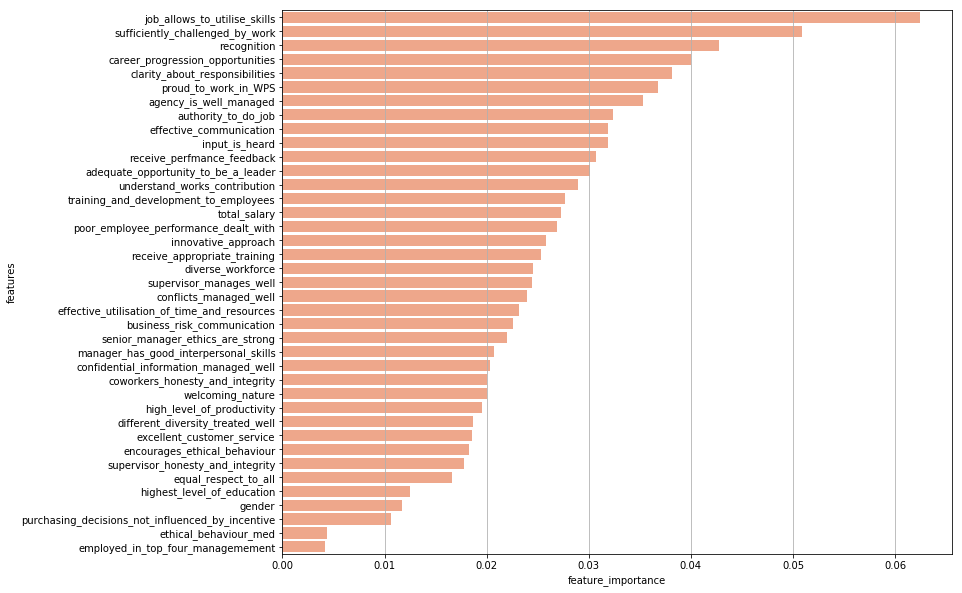

In [24]:
feature_imp = [x for x in zip(features,rf.feature_importances_)]
df = pd.DataFrame(feature_imp)
df.columns = ['features','feature_importance']
df.sort_values(by = 'feature_importance', ascending = False, inplace = True)

fig,ax = plt.subplots(figsize = (12,10))
sns.barplot(x = 'feature_importance' , y ='features', data = df, 
            orient= 'h', color = 'lightsalmon');
ax.grid(axis = 'x')

In [25]:
#redefine feature_cols,X,y - values were updated during plotting before
feature_cols = survey.drop(['target','target_plot'],axis=1).columns
X = survey[feature_cols]
y = survey.target

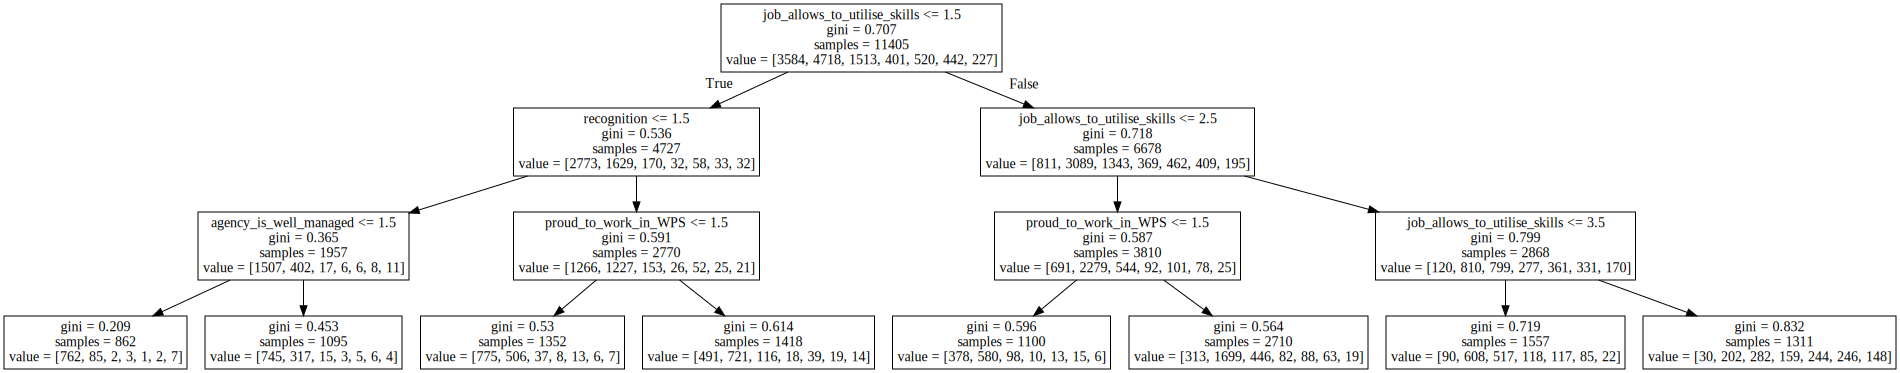

In [26]:
# Fitting a tree with max depth 3
treeclf = DecisionTreeClassifier(max_depth = 3, random_state=1)
treeclf.fit(X, y)

dot_data = export_graphviz(treeclf, out_file=None, feature_names=feature_cols)

graph = graphviz.Source(dot_data)  
graph 

In [27]:
def generate_report(clf):
    """Return y_pred. 
    Takes input as a classifier, fits the classifier to the X_train,y_train data, predicts X_test and 
    generates classification reports for predicting X_test. Also calculates average accuracy, f1_scores and 
    displays confusion matrix."""
    
    
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    #classification report
    print("Classification Report:\n{}".format(classification_report(y_test,y_pred)))
    
    #accuracy and confusion matrix
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred))) 
    print("\nConfusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))
    
    #micro,macro and weighted scores
    print("\nMicro average f1 score: {:.3f}".format (f1_score(y_test, y_pred, average="micro")))
    print("Macro average f1 score: {:.3f}".format (f1_score(y_test, y_pred, average="macro")))
    print("Weighted average f1 score: {:.3f}".format (f1_score(y_test, y_pred, average="weighted")))
    
    return y_pred

## Model Fitting

**Train Test Split**

In [28]:
#test train split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 123)

**Linear SVC**

In [29]:
svc = LinearSVC()
svc_train = generate_report(LinearSVC())

KeyboardInterrupt: 

**Logistic Regression**

In [ ]:
logreg = LogisticRegression()
logreg_train = generate_report(LogisticRegression())

**GradientBoostingClassifier**

In [ ]:
gbc = GradientBoostingClassifier()
gbc_train = generate_report(GradientBoostingClassifier(learning_rate=0.3))

**AdaBoost**

In [ ]:
ada = AdaBoostClassifier()
ada_train = generate_report(AdaBoostClassifier())

**Ensemble using Voting Classifier**

In [ ]:
estimators = []
model1 = logreg
estimators.append(('logistic', model1))
model2 = gbc
estimators.append(('gradient boosting classifier', model2))
model3 = svc
estimators.append(('svm', model3))
model4 = ada
estimators.append(('ada', model3))
# create the ensemble model
ensemble_clf = VotingClassifier(estimators=estimators,voting = 'hard')
results = cross_val_score(ensemble_clf, X, y, cv=3, scoring= 'accuracy', verbose = 1)
print(results.mean())

**Model Stacking**

In [ ]:
X = survey[feature_cols]
y = survey.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1, random_state = 60, stratify = y)

#create validation set for stacking
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.1,  
                                                       random_state = 60, stratify = y_train)

In [ ]:
model1 = logreg
model2 = gbc
model3 = svc
model4 = ada

#stack layer model
meta_model = LogisticRegression()

#fit models
print("Fiting Logistic Regression..")
model1.fit(X_train,y_train)
pred1 = model1.predict(X_test)
val1 = model1.predict(X_val)
print("Done")

print("Fiting GradientBoostedClassifier..")
model2.fit(X_train,y_train)
pred2 = model2.predict(X_test)
val2 = model2.predict(X_val)
print("Done")

print("Fitting LinearSVC..")
model3.fit(X_train,y_train)
pred3 = model3.predict(X_test)
val3 = model3.predict(X_val)
print("Done")

print("Fitting AdaBoostClassifier..")
model4.fit(X_train,y_train)
pred4 = model4.predict(X_test)
val4 = model4.predict(X_val)
print("Done")

#generate train data for stacking 
stacked_train = np.column_stack((pred1, pred2, pred3, pred4))
stacked_val = np.column_stack((val1, val2, val3, val4))

#train stacked model
print("Fitting Stacked Model..")
meta_model.fit(stacked_train,y_test)
y_pred = meta_model.predict(stacked_val)
print("Done")

#evaluation metrics for stacked model
print("Classification Report:\n{}".format(classification_report(y_val,y_pred)))

#accuracy and confusion matrix
print("Accuracy: {:.3f}".format(accuracy_score(y_val, y_pred))) 
print("\nConfusion matrix:\n{}".format(confusion_matrix(y_val, y_pred)))

#micro,macro and weighted scores
print("\nMicro average f1 score: {:.3f}".format (f1_score(y_val, y_pred, average="micro")))
print("Macro average f1 score: {:.3f}".format (f1_score(y_val, y_pred, average="macro")))
print("Weighted average f1 score: {:.3f}".format (f1_score(y_val, y_pred, average="weighted")))